# Temporal-Difference Methods

In this notebook, you will write your own implementations of many Temporal-Difference (TD) methods.

While we have provided some starter code, you are welcome to erase these hints and write your code from scratch.

---

### Part 0: Explore CliffWalkingEnv

We begin by importing the necessary packages.

In [148]:
import sys
import gym
import numpy as np
from collections import defaultdict, deque
import matplotlib.pyplot as plt
%matplotlib inline

import check_test
from plot_utils import plot_values

Use the code cell below to create an instance of the [CliffWalking](https://github.com/openai/gym/blob/master/gym/envs/toy_text/cliffwalking.py) environment.

In [149]:
env = gym.make('CliffWalking-v0')

The agent moves through a $4\times 12$ gridworld, with states numbered as follows:
```
[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11],
 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
 [24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35],
 [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]]
```
At the start of any episode, state `36` is the initial state.  State `47` is the only terminal state, and the cliff corresponds to states `37` through `46`.

The agent has 4 potential actions:
```
UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3
```

Thus, $\mathcal{S}^+=\{0, 1, \ldots, 47\}$, and $\mathcal{A} =\{0, 1, 2, 3\}$.  Verify this by running the code cell below.

In [150]:
print(env.action_space)
print(env.observation_space)
print(env.nA)

Discrete(4)
Discrete(48)
4


In [151]:
ss = []
for i in range(10):
    print(i, end='')
    s = env.reset()
    a = np.random.choice(env.nA)
    while True:
        next_s, reward, done, _ = env.step(a)
        if done:
            break
        s = next_s
        a = np.random.choice(env.nA)
        if s not in ss:
            ss.append(s) 
print('states:')
print(ss)

0123456789states:
[36, 24, 25, 12, 13, 14, 26, 0, 1, 2, 3, 15, 4, 16, 17, 18, 6, 5, 7, 19, 20, 32, 31, 30, 8, 9, 21, 28, 27, 29, 33, 22, 34, 35, 10, 23, 11]


In this mini-project, we will build towards finding the optimal policy for the CliffWalking environment.  The optimal state-value function is visualized below.  Please take the time now to make sure that you understand _why_ this is the optimal state-value function.

_**Note**: You can safely ignore the values of the cliff "states" as these are not true states from which the agent can make decisions.  For the cliff "states", the state-value function is not well-defined._

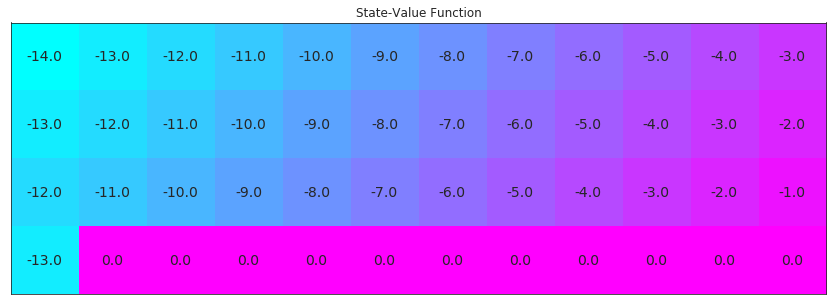

In [152]:
# define the optimal state-value function
V_opt = np.zeros((4,12))
V_opt[0:13][0] = -np.arange(3, 15)[::-1]
V_opt[0:13][1] = -np.arange(3, 15)[::-1] + 1
V_opt[0:13][2] = -np.arange(3, 15)[::-1] + 2
V_opt[3][0] = -13

plot_values(V_opt)

In [153]:
v_t = np.zeros((4,12))
v_t[0] = -np.arange(3, 15)[::-1]
v_t[1] = -np.arange(3, 15)[::-1]+1
v_t[2] = -np.arange(3, 15)[::-1]+2
v_t[3][0] = -13
print(v_t)

[[-14. -13. -12. -11. -10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.]
 [-13. -12. -11. -10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.]
 [-12. -11. -10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.]
 [-13.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]]


### Part 1: TD Control: Sarsa

In this section, you will write your own implementation of the Sarsa control algorithm.

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

Please complete the function in the code cell below.

(_Feel free to define additional functions to help you to organize your code._)

In [154]:
def update_sarsa(Q, state, action, reward, alpha, gamma, next_s=None, next_a=None):
    q_sa_p = Q[next_s][next_a] if next_s is not None else 0
    q_target = reward + gamma*q_sa_p
    q_current = Q[state][action]
    new_value = q_current + alpha*(q_target-q_current)
    return new_value

In [155]:
def eps_greedy(Q, state, nA, epsilon):
    if np.random.random() > epsilon:
        action = np.argmax(Q[state])
    else:
        action = np.random.choice(np.arange(nA))
    return action

In [156]:
def sarsa(env, num_episodes, alpha, gamma=1.0):
    # initialize action-value function (empty dictionary of arrays)
    Q = defaultdict(lambda: np.zeros(env.nA))
    # initialize performance monitor
    # loop over episodes
    temp_rewards = []
    average_rewards = []
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()   
        
        ## TODO: complete the function
        eps = 1.0 / i_episode 
        #eps = 0.1
        s = env.reset()
        a = policy(Q, s, env.nA, eps)
        
        reward_sum = 0
        temp_rewards = []
        while True:
            next_s, reward, done, _ = env.step(a)
            reward_sum += reward
            if not done:
                next_a = eps_greedy(Q, next_s, env.nA, eps)
                Q[s][a] = update_sarsa(Q, s, a, reward, alpha, gamma, next_s, next_a)
                s = next_s
                a = next_a
            else:
                Q[s][a] = update_sarsa(Q, s, a, reward, alpha, gamma)
                temp_rewards.append(reward_sum)
                break
        if (i_episode % 10 ==0):
            avg = np.mean(temp_rewards)
            average_rewards.append(avg)
    plt.plot(average_rewards)   
    plt.show()
    print(np.max(average_rewards))
    return Q, average_rewards

Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function.  

If the code cell returns **PASSED**, then you have implemented the function correctly!  Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

Episode 5000/5000

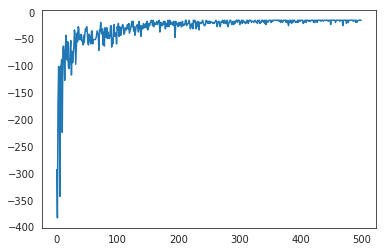

-15.0


**<span style="color: red;">PLEASE TRY AGAIN</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 1  1  1  1  1  2  1  1  1  1  2  1]
 [ 1  1  1  1  1  1  1  1  1  1  2  2]
 [ 0  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]


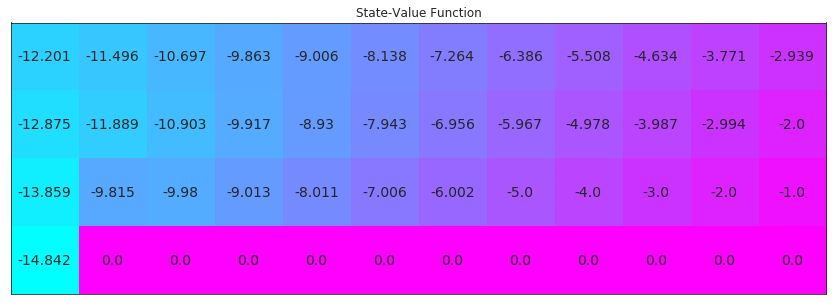

In [157]:
# obtain the estimated optimal policy and corresponding action-value function
Q_sarsa, sarsa_avg_rewards = sarsa(env, 5000, .01)

# print the estimated optimal policy
policy_sarsa = np.array([np.argmax(Q_sarsa[key]) if key in Q_sarsa else -1 for key in np.arange(48)]).reshape(4,12)
check_test.run_check('td_control_check', policy_sarsa)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_sarsa)

# plot the estimated optimal state-value function
V_sarsa = ([np.max(Q_sarsa[key]) if key in Q_sarsa else 0 for key in np.arange(48)])
plot_values(V_sarsa)

### Part 2: TD Control: Q-learning

In this section, you will write your own implementation of the Q-learning control algorithm.

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

Please complete the function in the code cell below.

(_Feel free to define additional functions to help you to organize your code._)

In [158]:
def update_qlearning(Q, state, action, reward, alpha, gamma, next_s=None):
    max_qs = max(Q[next_s]) if next_s is not None else 0
    q_target = reward + gamma*max_qs
    q_current = Q[state][action]
    new_value = q_current + alpha*(q_target-q_current)
    return new_value

In [159]:
def q_learning(env, num_episodes, alpha, gamma=1.0):
    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(env.nA))
    temp_rewards = []
    average_rewards = []
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        ## TODO: complete the function
        eps = 1.0 / i_episode 
        #eps = 0.1
        s = env.reset()
        a = eps_greedy(Q, s, env.nA, eps)
        
        reward_sum = 0
        temp_rewards = []
        while True:
            next_s, reward, done, _ = env.step(a)
            reward_sum += reward
            if not done:
                Q[s][a] = update_qlearning(Q, s, a, reward, alpha, gamma, next_s)
            else:
                Q[s][a] = update_qlearning(Q, s, a, reward, alpha, gamma)
                temp_rewards.append(reward_sum)
                break
            s = next_s
            a = eps_greedy(Q, s, env.nA, eps)
        if (i_episode % 10 ==0):
            avg = np.mean(temp_rewards)
            average_rewards.append(avg)
    plt.plot(average_rewards)   
    plt.show()
    print(np.max(average_rewards))
        
    return Q, average_rewards

Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function. 

If the code cell returns **PASSED**, then you have implemented the function correctly!  Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

Episode 5000/5000

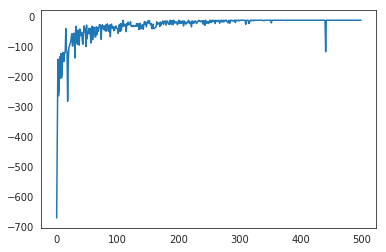

-13.0


**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 1  2  2  2  2  1  1  1  1  3  1  0]
 [ 3  0  0  1  1  1  1  2  1  1  2  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]


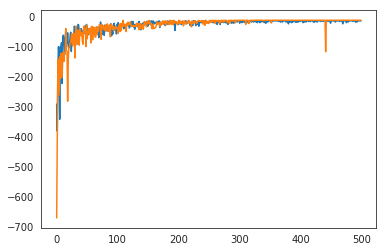

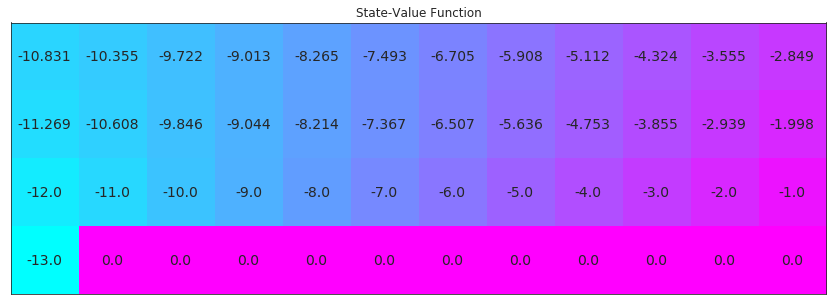

In [160]:
# obtain the estimated optimal policy and corresponding action-value function
Q_sarsamax, q_avg_rewards = q_learning(env, 5000, .01)
x = np.arange(len(q_avg_rewards))
plt.plot(x, sarsa_avg_rewards, q_avg_rewards)

# print the estimated optimal policy
policy_sarsamax = np.array([np.argmax(Q_sarsamax[key]) if key in Q_sarsamax else -1 for key in np.arange(48)]).reshape((4,12))
check_test.run_check('td_control_check', policy_sarsamax)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_sarsamax)

# plot the estimated optimal state-value function
plot_values([np.max(Q_sarsamax[key]) if key in Q_sarsamax else 0 for key in np.arange(48)])

### Part 3: TD Control: Expected Sarsa

In this section, you will write your own implementation of the Expected Sarsa control algorithm.

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

Please complete the function in the code cell below.

(_Feel free to define additional functions to help you to organize your code._)

In [161]:
def update_expected_sarsa(Q, policy_probs, state, action, reward, alpha, gamma, next_s=None):    
    expected_q_sp = np.dot(policy_probs, Q[next_s]) if next_s is not None else 0
    q_target = reward + gamma*expected_q_sp
    q_current = Q[state][action]
    new_value = q_current + alpha*(q_target-q_current)
    return new_value

In [162]:
def policy_probs(Q, state, nA, epsilon):
    probs = epsilon*np.ones(nA, dtype=float)/nA
    max_idx = np.argmax(Q[state])
    probs[max_idx] += 1-epsilon
    return probs

In [173]:
def expected_sarsa(env, num_episodes, alpha, gamma=1.0):
    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(env.nA))
    average_rewards = []
    # loop over episodes
    np.random.seed(1)
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        ## TODO: complete the function
        eps = 1.0 / i_episode 
        eps = 0.005
        s = env.reset()
        
        reward_sum = 0
        temp_rewards = []
        while True:
            a = eps_greedy(Q, s, env.nA, eps)
            next_s, reward, done, _ = env.step(a)
            reward_sum += reward
            if not done:
                probs = policy_probs(Q, next_s, env.nA, eps)
                Q[s][a] = update_expected_sarsa(Q, probs, s, a, reward, alpha, gamma, next_s)
                s = next_s
            else:
                Q[s][a] = update_expected_sarsa(Q, probs, s, a, reward, alpha, gamma)
                temp_rewards.append(reward_sum)
                break
            
        if (i_episode % 100 ==0):
            avg = np.mean(temp_rewards)
            average_rewards.append(avg)
    plt.plot(average_rewards)   
    plt.show()
    print(np.max(average_rewards))        
    return Q, average_rewards

Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function.  

If the code cell returns **PASSED**, then you have implemented the function correctly!  Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

Episode 5000/5000

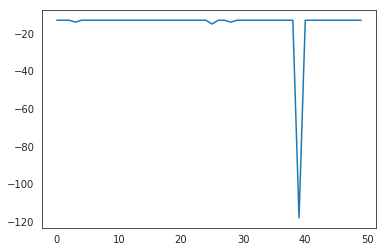

-13.0


**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 1  0  1  1  1  3  1  1  0  1  1  3]
 [ 0  1  1  1  1  1  1  1  1  1  1  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]


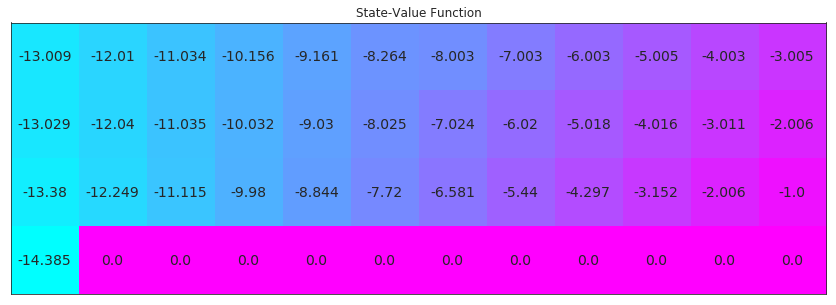

In [175]:
# obtain the estimated optimal policy and corresponding action-value function
Q_expsarsa, average_rewards = expected_sarsa(env, 5000, 1)

# print the estimated optimal policy
policy_expsarsa = np.array([np.argmax(Q_expsarsa[key]) if key in Q_expsarsa else -1 for key in np.arange(48)]).reshape(4,12)
check_test.run_check('td_control_check', policy_expsarsa)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_expsarsa)

# plot the estimated optimal state-value function
plot_values([np.max(Q_expsarsa[key]) if key in Q_expsarsa else 0 for key in np.arange(48)])